In [1]:
from scipy.sparse import csr_matrix
from sklearn import metrics
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
import sys
from sklearn.utils import shuffle
from sklearn.metrics import silhouette_score 
import numpy as np

In [2]:
colList = list()
rowList = list()
dataList = list()
with open('data/train.dat', 'r') as fileData:
    datalines = fileData.readlines();
    totalcolumns = 0;
    shapeCount = 0 # variable to calculate the shape size
    totalrows = len(datalines)  
   
    for i in range(totalrows):
        dataVar = datalines[i].split()
        if len(dataVar) % 2 != 0:
            raise ValueError("Total no.of keys mismatches the total no.of values. It is an invalid compressed sparse row matrix.")
        shapeCount += len(dataVar)//2 #Rounding off to its previous integer value to avoid decimals while calculating shape size.
        for j in range(0, len(dataVar), 2): 
            cols = int(dataVar[j]) - 1;
            if cols+1 > totalcolumns:
                totalcolumns = cols+1;

data = np.zeros(shapeCount, dtype=np.single) #
indices = np.zeros(shapeCount, dtype=np.intc) #
indptr = np.zeros(totalrows+1, dtype=np.longlong) #
n = 0  #
for i in range(totalrows):
    dataVar = datalines[i].split()
    for j in range(0, len(dataVar), 2): 
        indices[n] = int(dataVar[j]) - 1
        data[n] = float(dataVar[j+1])
        n += 1
    indptr[i+1] = n 
#csr_matrix((data, indices, indptr), [shape=(M, N)])
#is the standard CSR representation where the column indices for row i are stored in indices[indptr[i]:indptr[i+1]] 
#and their corresponding values are stored in data[indptr[i]:indptr[i+1]]. 
#If the shape parameter is not supplied, the matrix dimensions are inferred from the index arrays.       
csrMatrixData=csr_matrix((data, indices, indptr), shape=(totalrows, totalcolumns), dtype=np.single)

In [3]:
from sklearn.feature_extraction.text import TfidfTransformer
#Transform a count matrix to a normalized tf or tf-idf representation.
tdidfTransformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=False) 
sparse_matrix = tdidfTransformer.fit_transform(csrMatrixData).toarray();

C:\Users\Checkout\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:1641: RuntimeWarning: divide by zero encountered in divide
  idf = np.log(n_samples / df) + 1


In [4]:
%%time
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=220,n_iter=7)
#reducing the no.of dimensions for the obtained sparse matrix.
X = svd.fit_transform(sparse_matrix)

CPU times: total: 12min 7s
Wall time: 2min 45s


In [6]:
def kmeans(matrix, numberOfIterations):
    
    #shuffling the matrix to randomly fetch two centroids for the given matrix.
    newMatrix = shuffle(matrix, random_state=0)   
    centroids = newMatrix[:2,:];
    
    for index in range(numberOfIterations):     
        #Calculating dot product of the given matrices. A*Transpose(B) to check the similarity between them.
        matrixSimilarity = matrix.dot(centroids.T)          
      
        firstCluster = list()
        secondCluster = list()
        #creating clusters
        for i in range(matrixSimilarity.shape[0]):
            row = matrixSimilarity[i]        
            sortedMatrix = np.argsort(row)[-1]        
            if sortedMatrix == 0:
                firstCluster.append(i)
            else:
                secondCluster.append(i)  
                
        clustersList = list() 
        if len(firstCluster) > 1:
            clustersList.append(firstCluster)
        if len(secondCluster) > 1:
            clustersList.append(secondCluster)            
        # re-calculating the centroids for the clsuters.
        centroidList = list()    
        for i in range(0,2):
            clusterData = matrix[clustersList[i],:]
            meanOfCluster = clusterData.mean(0)
            centroidList.append(meanOfCluster)
            
        centroids = np.asarray(centroidList)
        
    return firstCluster, secondCluster

In [7]:
def evaluateSSE(matrix, clusters):
    sseArray = [];
    sseList = list();    
    
    for clusterVar in clusters:
        maxtrixItem = matrix[clusterVar,:]
        sumOfSquares = np.sum(np.square(maxtrixItem - np.mean(maxtrixItem)))
        sseList.append(sumOfSquares)
        
    sseArray = np.asarray(sseList)
    clusterIndex = np.argsort(sseArray)[-1]
    # return index of the cluster which has highest sum of squares value.        
    return clusterIndex

In [8]:
from sklearn.cluster import KMeans
def bisecting_kmeans(matrix, k, iterations):
    
    startingCluster = list();
    clustersList = list();    
    
    for i in range(matrix.shape[0]):
        startingCluster.append(i)
    
    clustersList.append(startingCluster);    
  
    while len(clustersList) < k:

        clusterIndex = evaluateSSE(matrix, clustersList)
        droppedCluster = clustersList[clusterIndex]
        
        firstCluster, secondCluster = kmeans(matrix[droppedCluster,:], iterations)
        del clustersList[clusterIndex]
        
        cluster1 = list();
        cluster2 = list();
        for index in firstCluster:
            cluster1.append(droppedCluster[index])
            
        for index in secondCluster:
            cluster2.append(droppedCluster[index])
        
        clustersList.append(cluster1);
        clustersList.append(cluster2);
    
    clusterCollection = [0] * matrix.shape[0];    
     
    for index, cluster in enumerate(clustersList):
        for idx in cluster:
            clusterCollection[idx] = index + 1
    return clusterCollection

In [9]:
from sklearn.metrics import calinski_harabasz_score
kValuesList = list()
scoresList = list()
harabazScoreList = list()

for k in range(3, 21, 2):
    labels = bisecting_kmeans(X, k, 10)
    if (k == 7):        
        outputFile = open("predictionFile.dat", "w")
        for index in labels:
            outputFile.write(str(index) +'\n')
        outputFile.close()
   
    silhouetteScore = silhouette_score(X, labels)
    harabazScore = calinski_harabasz_score(X, labels)
    kValuesList.append(k)
    scoresList.append(silhouetteScore)
    harabazScoreList.append(harabazScore)
    print ("Silhouette Score for value K = %d => %f" %(k, silhouetteScore))
    print ("HarabazScore Score for value K = %d => %f" %(k, harabazScore))
   
 

Silhouette Score for value K = 3 => 0.011240
HarabazScore Score for value K = 3 => 193.757863
Silhouette Score for value K = 5 => 0.028402
HarabazScore Score for value K = 5 => 185.568862
Silhouette Score for value K = 7 => 0.034355
HarabazScore Score for value K = 7 => 176.088204
Silhouette Score for value K = 9 => -0.025301
HarabazScore Score for value K = 9 => 147.690835
Silhouette Score for value K = 11 => -0.013504
HarabazScore Score for value K = 11 => 143.639628
Silhouette Score for value K = 13 => -0.006928
HarabazScore Score for value K = 13 => 132.881215
Silhouette Score for value K = 15 => -0.005733
HarabazScore Score for value K = 15 => 120.946800
Silhouette Score for value K = 17 => -0.010418
HarabazScore Score for value K = 17 => 107.727452
Silhouette Score for value K = 19 => -0.003923
HarabazScore Score for value K = 19 => 103.974007


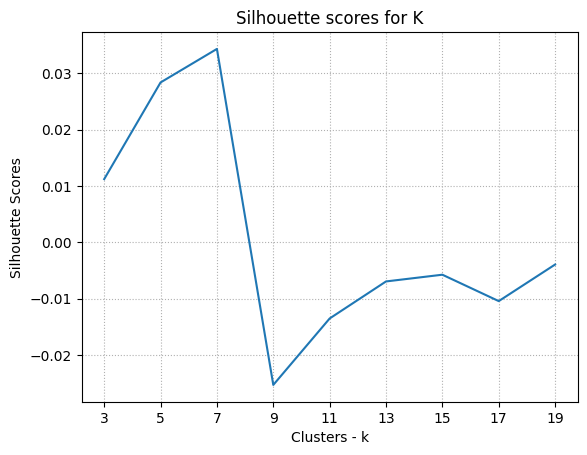

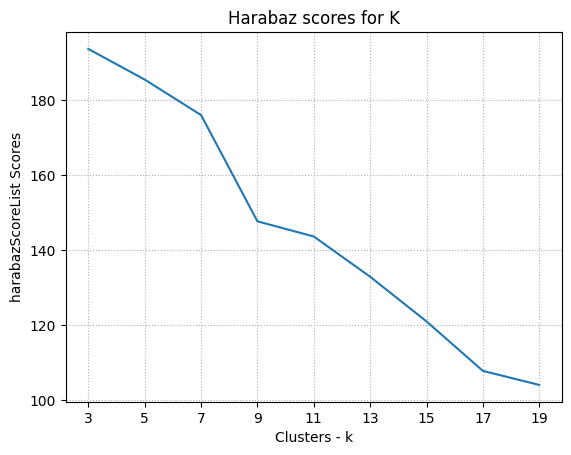

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(kValuesList, scoresList)
plt.xticks(kValuesList, kValuesList)
plt.xlabel('Clusters - k')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette scores for K')
plt.grid(linestyle='dotted')

plt.savefig('Silhouette.png')
plt.show()


plt.plot(kValuesList, harabazScoreList)
plt.xticks(kValuesList, kValuesList)
plt.xlabel('Clusters - k')
plt.ylabel('harabazScoreList Scores')
plt.title('Harabaz scores for K')
plt.grid(linestyle='dotted')

plt.savefig('harabaz.png')
plt.show()